<a href="https://colab.research.google.com/github/DARSHITA2804/DEEPLEARNING/blob/main/lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio

!pip install tensorflow


Starting training SimpleRNN on 120 sequences...
Epoch   0 Loss: 0.11418664
Epoch  20 Loss: 0.00629161
Epoch  40 Loss: 0.00531148
Epoch  60 Loss: 0.01036970
Epoch  80 Loss: 0.00373696
Final Loss: 0.00587350
Training complete!


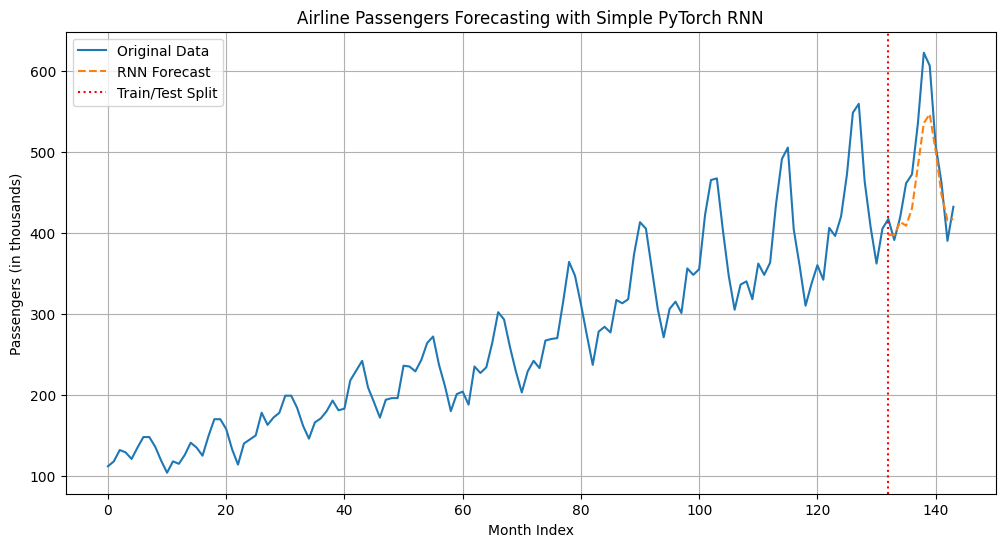

In [7]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

data = sns.load_dataset("flights")
all_data = data['passengers'].values.astype(float)

test_data_size = 12
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        super().__init__()
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx][0], self.sequences[idx][1]

train_dataset = TimeSeriesDataset(train_inout_seq)
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):

        rnn_input = input_seq.unsqueeze(-1)

        h0 = torch.zeros(1, rnn_input.size(0), self.hidden_layer_size).to(input_seq.device)

        rnn_out, h_n = self.rnn(rnn_input, h0)

        predictions = self.linear(rnn_out[:, -1, :])
        return predictions

input_dim = 1
hidden_dim = 100
output_dim = 1
learning_rate = 0.001
num_epochs = 100

model = SimpleRNN(input_dim, hidden_dim, output_dim)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Starting training SimpleRNN on {len(train_inout_seq)} sequences...")

for epoch in range(num_epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)

        single_loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch:3} Loss: {single_loss.item():10.8f}')

print(f'Final Loss: {single_loss.item():10.8f}')
print("Training complete!")

model.eval()

test_input = scaler.transform(test_data.reshape(-1, 1))
test_input = torch.FloatTensor(test_input).view(-1)

fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])

    with torch.no_grad():

        y_pred = model(seq.unsqueeze(0)).squeeze()

    test_inputs.append(y_pred.item())

actual_predictions = test_inputs[-fut_pred:]

actual_predictions = np.array(actual_predictions).reshape(-1, 1)
actual_predictions = scaler.inverse_transform(actual_predictions).flatten()

x_all = np.arange(len(all_data))
x_test = np.arange(len(train_data), len(all_data))

plt.figure(figsize=(12, 6))
plt.title('Airline Passengers Forecasting with Simple PyTorch RNN')
plt.ylabel('Passengers (in thousands)')
plt.xlabel('Month Index')
plt.grid(True)
plt.plot(x_all, all_data, label='Original Data')
plt.plot(x_test, actual_predictions, label='RNN Forecast', linestyle='--')
plt.axvline(x=len(train_data), color='r', linestyle=':', label='Train/Test Split')
plt.legend()
plt.show()